In [65]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

import pyarrow as pa
import pyarrow.parquet as pq
import math
import datetime
from datetime import timedelta
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [85]:
# TODO - we want to optimise the holding period - since there arent many trades, want to up the yield per trade
# set the date for date loc
date_loc = '2020-07-28'
lookback = 500 # this is 100 lots of resample_period
resample_period = "10ms"

filename_futures_quotes = "/Volumes/GoogleDrive/Shared drives/data/jeff_usdjpy_20200728_quotes.csv"
filename_futures_trades = "/Volumes/GoogleDrive/Shared drives/data/jeff_usdjpy_20200727_20200731_trades_clients"



In [86]:
def ofi(quotes,level):
    """Returns Order Flow Imbalance for given levels of the orderbook"""
    qdf = quotes.copy()
    bid_price_label = 'Bid' + str(level)
    offer_price_label = 'Offer' + str(level)
    bid_qty_label = 'Bid' +str(level) + 'Qty'
    offer_qty_label = 'Offer' + str(level)+'Qty'

    qdf['prev_bidprice'] = qdf[bid_price_label].shift()
    qdf['prev_bidsize'] = qdf[bid_qty_label].shift()
    qdf['prev_askprice'] = qdf[offer_price_label].shift()
    qdf['prev_asksize'] = qdf[offer_qty_label].shift()

    # Fix any missing/invalid data
    qdf.replace([np.inf, np.NINF], np.nan, inplace=True)
    qdf.fillna(method="ffill", inplace=True)
    qdf.fillna(method="bfill", inplace=True)
    
    bid_geq = qdf[bid_price_label] >= qdf['prev_bidprice']
    bid_leq = qdf[bid_price_label] <= qdf['prev_bidprice']
    ask_geq = qdf[offer_price_label] >= qdf['prev_askprice']
    ask_leq = qdf[offer_price_label] <= qdf['prev_askprice']
    
    qdf['ofi'] = np.zeros(len(qdf))
    qdf['ofi'].loc[bid_geq] += qdf[bid_qty_label].loc[bid_geq]
    qdf['ofi'].loc[bid_leq] -= qdf['prev_bidsize'].loc[bid_leq]
    qdf['ofi'].loc[ask_geq] += qdf['prev_asksize'].loc[ask_geq]
    qdf['ofi'].loc[ask_leq] -= qdf[offer_qty_label].loc[ask_leq]    
    return qdf['ofi']

In [87]:
# %% Read the order book data for futures

df_quotes = pd.read_csv(filename_futures_quotes)


df_quotes['t'] = pd.to_datetime(df_quotes['t'],errors='coerce')
df_quotes.set_index("t",inplace=True)
#df_all  = df_all.resample("100ms").last()

df_quotes["Offer0Qty"] = df_quotes["Offer0Qty"].astype('float')
df_quotes["Offer0"] = df_quotes["Offer0"].astype('float')
df_quotes["Bid0"] = df_quotes["Bid0"].astype('float')
df_quotes["Bid0Qty"] = df_quotes["Bid0Qty"].astype('float')

df_quotes["Offer1Qty"] = df_quotes["Offer1Qty"].astype('float')
df_quotes["Offer1"] = df_quotes["Offer1"].astype('float')
df_quotes["Bid1"] = df_quotes["Bid1"].astype('float')
df_quotes["Bid1Qty"] = df_quotes["Bid1Qty"].astype('float')

df_quotes["Offer2Qty"] = df_quotes["Offer2Qty"].astype('float')
df_quotes["Offer2"] = df_quotes["Offer2"].astype('float')
df_quotes["Bid2"] = df_quotes["Bid2"].astype('float')
df_quotes["Bid2Qty"] = df_quotes["Bid2Qty"].astype('float')

df_quotes["Offer3Qty"] = df_quotes["Offer3Qty"].astype('float')
df_quotes["Offer3"] = df_quotes["Offer3"].astype('float')
df_quotes["Bid3"] = df_quotes["Bid3"].astype('float')
df_quotes["Bid3Qty"] = df_quotes["Bid3Qty"].astype('float')

df_quotes["Offer4Qty"] = df_quotes["Offer4Qty"].astype('float')
df_quotes["Offer4"] = df_quotes["Offer4"].astype('float')
df_quotes["Bid4"] = df_quotes["Bid4"].astype('float')
df_quotes["Bid4Qty"] = df_quotes["Bid4Qty"].astype('float')
df_quotes['market_mid'] = (df_quotes['Bid0'] + df_quotes['Offer0']) / 2

df_quotes = df_quotes.loc[date_loc]

#remove the duplicates
df_quotes = df_quotes.loc[~df_quotes.index.duplicated(keep='last')]

In [88]:
########################
# OFI using top x levels 
########################

df_quotes = df_quotes.resample(resample_period).last().ffill()
df_quotes = df_quotes

df_quotes["Offer0Qty"] = df_quotes["Offer0Qty"].astype('float')
df_quotes["Offer0"] = df_quotes["Offer0"].astype('float')
df_quotes["Bid0"] = df_quotes["Bid0"].astype('float')
df_quotes["Bid0Qty"] = df_quotes["Bid0Qty"].astype('float')

df_quotes["Offer1Qty"] = df_quotes["Offer1Qty"].astype('float')
df_quotes["Offer1"] = df_quotes["Offer1"].astype('float')
df_quotes["Bid1"] = df_quotes["Bid1"].astype('float')
df_quotes["Bid1Qty"] = df_quotes["Bid1Qty"].astype('float')

df_quotes["Offer2Qty"] = df_quotes["Offer2Qty"].astype('float')
df_quotes["Offer2"] = df_quotes["Offer2"].astype('float')
df_quotes["Bid2"] = df_quotes["Bid2"].astype('float')
df_quotes["Bid2Qty"] = df_quotes["Bid2Qty"].astype('float')

df_quotes["Offer3Qty"] = df_quotes["Offer3Qty"].astype('float')
df_quotes["Offer3"] = df_quotes["Offer3"].astype('float')
df_quotes["Bid3"] = df_quotes["Bid3"].astype('float')
df_quotes["Bid3Qty"] = df_quotes["Bid3Qty"].astype('float')

df_quotes["Offer4Qty"] = df_quotes["Offer4Qty"].astype('float')
df_quotes["Offer4"] = df_quotes["Offer4"].astype('float')
df_quotes["Bid4"] = df_quotes["Bid4"].astype('float')
df_quotes["Bid4Qty"] = df_quotes["Bid4Qty"].astype('float')



Cumulative PnL 0.17043841333941012


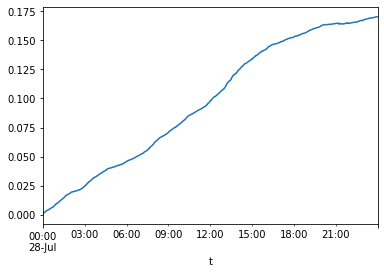

In [89]:
# OFI levels 1, 2 and 3
# moving average sets position change speed

df_quotes['ofi'] = ofi(df_quotes,1) + ofi(df_quotes,2) + ofi(df_quotes,3) 
df_quotes['ofi_signal'] = np.where(df_quotes['ofi'].rolling(lookback).mean() > 0, 1, -1)
df_quotes['mid'] = ((df_quotes['Bid0'] + df_quotes['Offer0']) / 2.0)
df_quotes['mid_change'] = ((df_quotes['Bid0'] + df_quotes['Offer0']) / 2.0).pct_change()

# shift the signal
df_quotes['ofi_signal'] = df_quotes['ofi_signal'].shift(1)
df_quotes['ofi_pnl'] = (df_quotes['ofi_signal'] * df_quotes['mid_change'])

print("Cumulative PnL " + str(df_quotes['ofi_pnl'].cumsum().iloc[-1]))

#plot
df_quotes['ofi_pnl'].cumsum().resample("1T").last().plot()
#add a suffix
df_quotes = df_quotes.add_suffix('_quotes')

In [90]:
# Load trades
df_trades = pd.read_csv(filename_futures_trades+ ".csv")

#Function that adds the rolling long ash short position to the dataframe and average fill
df_trades['buys_factor'] = 0 # delete after use
df_trades['sells_factor'] = 0 # delete after use

df_trades.loc[df_trades['side'] == 'sell','sells_factor'] = df_trades['fillPrice'] * df_trades['filledQuantity'] 
df_trades.loc[df_trades['side'] == 'buy','buys_factor'] = df_trades['fillPrice'] * df_trades['filledQuantity']
df_trades.loc[df_trades['side'] == 'sell','cum_sell'] = df_trades.loc[df_trades['side'] == 'sell','filledQuantity'].cumsum()
df_trades.loc[df_trades['side'] == 'buy','cum_buys'] = df_trades.loc[df_trades['side'] == 'buy','filledQuantity'].cumsum()
df_trades.loc[df_trades['side'] == 'sell','average_sell_price'] = df_trades['sells_factor'].cumsum() / df_trades['cum_sell']
df_trades.loc[df_trades['side'] == 'buy','average_buy_price'] = df_trades['buys_factor'].cumsum() / df_trades['cum_buys']

# Set the index
df_trades["timestamp"] = df_trades["transactTime"] 
df_trades["timestamp"] = pd.to_datetime(df_trades["timestamp"])

df_trades.set_index("timestamp", inplace=True)
df_trades.sort_index(inplace=True)

#drop unused columns
df_trades = df_trades.loc[date_loc]

#add the OFI to the trade 
df = df_trades.join(df_quotes, how='outer')
df.sort_index(inplace=True)

df['time'] = df.index
df = df.reset_index(drop=True)

cols = ['ofi_signal_quotes','cum_sell','average_sell_price','cum_buys','average_buy_price']
df.loc[:,cols] = df.loc[:,cols].fillna(method="ffill")

df = df.loc[df['filledQuantity'] > 0]


In [91]:
cols = [
"time",
"key",
"baseQuantityUsd", 
"usdPnl",
"usdPnl", 
"PT0S", 
"usdPnl-PT0.1S", 
"usdPnl-PT0.5S", 
"usdPnl-PT1S", 
"usdPnl-PT5S", 
"usdPnl-PT10S", 
"usdPnl-PT30S", 
"usdPnl-PT1M", 
"usdPnl-PT2M", 
"usdPnl-PT4M", 
"usdPnl-PT8M", 
"usdPnl-PT12M", 
"usdPnl-PT16M", 
"usdPnl-PT20M", 
"usdPnl-PT40M", 
"usdPnl-PT1H", 
"usdPnl-PT1H30M", 
"usdPnl-PT2H", 
"side", 
"ofi_signal_quotes"]



In [92]:
df.loc[:,cols].to_clipboard()

